### Importing Libraries

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torch.quantization import prepare, convert, fuse_modules
import time
import io
import matplotlib.pyplot as plt
from torch.ao.quantization import move_exported_model_to_eval
from torch._export import capture_pre_autograd_graph
from torch.ao.quantization.quantize_pt2e import (
    prepare_pt2e,
    convert_pt2e,
)
from torch.ao.quantization.quantizer.xnnpack_quantizer import XNNPACKQuantizer
from torch.ao.quantization.quantizer.xnnpack_quantizer import get_symmetric_quantization_config

# Set up warnings
import warnings
warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning,
    module=r'.*'
)
warnings.filterwarnings(
    action='default',
    module=r'torch.ao.quantization'
) 

### Load the Pre-trained model and dataset

In [3]:
# 1. Load pretrained model
model_fp32 = resnet18(pretrained=True)
model_fp32.eval()

/home/mcw/Desktop/Quantization/quant_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mcw/Desktop/Quantization/quant_venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Preprocessing the dataset

In [4]:
# 5. Load and preprocess ImageNet-Mini Dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
imagenet_mini_path = '/home/mcw/Downloads/archive/imagenet-mini/val'
dataset = torchvision.datasets.ImageFolder(imagenet_mini_path, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

### Static Quantization

In [5]:
# 5. Prepare example input
example_inputs = (next(iter(loader))[0],)

# 6. Capture graph (Pre-Autograd Graph Mode Export)
model_exp = capture_pre_autograd_graph(model_fp32, example_inputs)

# 7. Apply PT2E Static Quantization
quantizer = XNNPACKQuantizer().set_global(get_symmetric_quantization_config())

model_prepared = prepare_pt2e(model_exp, quantizer)

# 8. Calibration
print("Calibrating...")
with torch.no_grad():
    for images, _ in loader:
        model_prepared(images)

for name, module in model_prepared.named_modules():
    if hasattr(module, 'quantization_annotation'):
        print(f"\n== {name} ==")
        print(module.quantization_annotation)

# 9. Convert to Quantized Model
model_int8 = convert_pt2e(model_prepared)

W0423 16:59:10.529000 41285 torch/_export/__init__.py:67] +============================+
W0423 16:59:10.533000 41285 torch/_export/__init__.py:68] |     !!!   WARNING   !!!    |
W0423 16:59:10.536000 41285 torch/_export/__init__.py:69] +============================+
W0423 16:59:10.539000 41285 torch/_export/__init__.py:70] capture_pre_autograd_graph() is deprecated and doesn't provide any function guarantee moving forward.
W0423 16:59:10.541000 41285 torch/_export/__init__.py:71] Please switch to use torch.export.export_for_training instead.


Calibrating...


/home/mcw/Desktop/Quantization/quant_venv/lib/python3.12/site-packages/torch/fx/graph.py:1199: UserWarning: erase_node(_native_batch_norm_legit_no_training) on an already erased node
  warnings.warn(f"erase_node({to_erase}) on an already erased node")
/home/mcw/Desktop/Quantization/quant_venv/lib/python3.12/site-packages/torch/fx/graph.py:1199: UserWarning: erase_node(_native_batch_norm_legit_no_training_1) on an already erased node
  warnings.warn(f"erase_node({to_erase}) on an already erased node")
/home/mcw/Desktop/Quantization/quant_venv/lib/python3.12/site-packages/torch/fx/graph.py:1199: UserWarning: erase_node(_native_batch_norm_legit_no_training_2) on an already erased node
  warnings.warn(f"erase_node({to_erase}) on an already erased node")
/home/mcw/Desktop/Quantization/quant_venv/lib/python3.12/site-packages/torch/fx/graph.py:1199: UserWarning: erase_node(_native_batch_norm_legit_no_training_3) on an already erased node
  warnings.warn(f"erase_node({to_erase}) on an already 

### Evaluating Helper functions

In [6]:
def evaluate(model, dataloader, is_exported=False):
    if is_exported:
        move_exported_model_to_eval(model)  # Only needed for PT2E exported models
    else:
        model.eval()

    correct = 0
    total = 0
    with torch.inference_mode():
        for images, labels in dataloader:
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total



def get_model_size(model):
    buffer = io.BytesIO()
    torch.save(model.state_dict(), buffer)
    return buffer.getbuffer().nbytes / 1e6

### Evaluation

In [7]:
# 9. Evaluate both models
acc_fp32 = evaluate(model_fp32, loader, is_exported=False) * 100
acc_int8 = evaluate(model_int8, loader, is_exported=True) * 100

size_fp32 = get_model_size(model_fp32)
size_int8 = get_model_size(model_int8)

print(f"FP32 Accuracy: {acc_fp32:.2f}%")
print(f"INT8 Accuracy (PT2E): {acc_int8:.2f}%")
print(f"FP32 Model Size: {size_fp32:.2f} MB")
print(f"INT8 Model Size: {size_int8:.2f} MB")

FP32 Accuracy: 69.97%
INT8 Accuracy (PT2E): 69.33%
FP32 Model Size: 46.83 MB
INT8 Model Size: 11.71 MB


### Plot Comparison

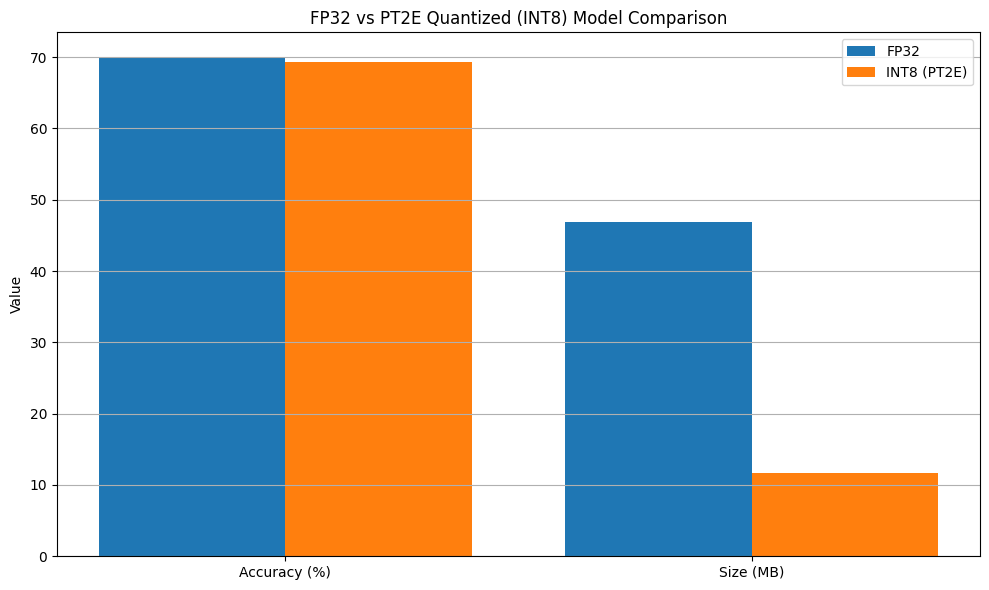

In [8]:
# 10. Plot Comparison
labels = ['Accuracy (%)', 'Size (MB)']
fp32_vals = [acc_fp32, size_fp32]
int8_vals = [acc_int8, size_int8]

x = range(len(labels))
plt.figure(figsize=(10, 6))
plt.bar(x, fp32_vals, width=0.4, label='FP32', align='center')
plt.bar([p + 0.4 for p in x], int8_vals, width=0.4, label='INT8 (PT2E)', align='center')
plt.xticks([p + 0.2 for p in x], labels)
plt.ylabel("Value")
plt.title("FP32 vs PT2E Quantized (INT8) Model Comparison")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()